# Solving Grid World Problem

**Set of algorithms used to solve control problem:**
- Iterative Policy Evaluation
- Policy Improvement 
- Value Iteration
- Monte-Carlo Policy Evaluation
- Monte-Carlo Control with Exploring Start 
- Monte-Carlo Control without Exploring Start 
- TD(0)
- SARSA
- Q-Learning
- Approximation Monte-Carlo prediction
- Approximation TD(0) prediciton
- Approximation Semi-Gradient SARSA control
- Approximation Q-Learning



In [0]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Grid: # Environment
  def __init__(self, width, height, start):
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]
  
  def current_state(self):
    return (self.i, self.j)
  
  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == "U":
        self.i -= 1
      elif action == "D":
        self.i += 1
      elif action == "R":
        self.j += 1
      elif action == "L":
        self.j -= 1
      
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == "U":
      self.i += 1
    elif action == "D":
      self.i -= 1
    elif action == "R":
      self.j -= 1
    elif action == "L":
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j not in self.actions)
  
  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(list(self.actions.keys()) + list(self.rewards.keys()))

In [0]:
def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and pssible actions at each state
  # the grid looks like this
  # x means you can't go there
  # number means reward at that state
  # . . .  1
  # . x . -1
  # s . . .
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
      (0,0): ('D', 'R'),
      (0,1): ('L', 'R'),
      (0,2): ('L', 'D', 'R'),
      (1,0): ('U', 'D'),
      (1,2): ('U', 'D', 'R'),
      (2,0): ('U', 'R'),
      (2,1): ('L', 'R'),
      (2,2): ('L', 'R', 'U'),
      (2,3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g

In [0]:
def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g

In [0]:
def play_game(agent, env):
  pass

In [0]:
# Set parameter
SMALL_ENOUGH = 10e-4 # threshold for convergence

In [0]:
def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

## Iterative Policy Evaluation

Given a policy, let's find it's value function V(s) we will do this for both a uniform random policy and fixed policy.

Note: There are 2 sources of randomness p(a|s) - deciding what action to take given the state p(s', r|s,a) - the next state and reward given your action-state pair we are only modeling p(a|s) = uniform 

how would the code change if p(s', r|s,a) is not deterministic?

In [0]:
grid = standard_grid()

In [0]:
# states will be positions (i, j)
# simpler than tic-tac-toe because we only have one "game piece"
# that can only be at one position at a time
states = grid.all_states()

In [100]:
  # uniformly random actions ###
  # initialize V(s) = 0
  V = {}
  for s in states:
    V[s] = 0
  gamma = 1.0 # discount factor
  # repeat until convergence
  while True:
    biggest_change = 0
    for s in states:
      old_v = V[s]

      # V(s) only has value if it's not a terminal state
      if s in grid.actions:

        new_v = 0 # we will accumulate the answer
        p_a = 1.0 / len(grid.actions[s]) # each action has equal probability
        for a in grid.actions[s]:
          grid.set_state(s)
          r = grid.move(a)
          new_v += p_a * (r + gamma * V[grid.current_state()])
        V[s] = new_v
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    if biggest_change < SMALL_ENOUGH:
      break
  print("values for uniformly random actions:")
  print_values(V, grid)
  print("\n\n")

values for uniformly random actions:
---------------------------
-0.03| 0.09| 0.22| 0.00|
---------------------------
-0.16| 0.00|-0.44| 0.00|
---------------------------
-0.29|-0.41|-0.54|-0.77|





In [101]:
# fixed policy
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }
  print_policy(policy, grid)

---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


In [0]:
# initialize V(s) = 0
V = {}
for s in states:
  V[s] = 0

# let's see how V(s) changes as we get further away from the reward
gamma = 0.9 # discount factor

In [103]:
 # repeat until convergence
  while True:
    biggest_change = 0
    for s in states:
      old_v = V[s]

      # V(s) only has value if it's not a terminal state
      if s in policy:
        a = policy[s]
        grid.set_state(s)
        r = grid.move(a)
        V[s] = r + gamma * V[grid.current_state()]
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    if biggest_change < SMALL_ENOUGH:
      break
  print("values for fixed policy:")
  print_values(V, grid)

values for fixed policy:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|


## Policy Improvement - Control Problem

How to find better policies --> optimal policy.

This approach is greedy, never considers globally the value-function at all states, it only looks at the current state s. 

When we've found the optimal policy, the policy $\pi$ won't change w.r.t the value-function. Additionally, the value-funciton will no longer improve it'll stay constant.

**Policy Iteration**

Policy iteration is an algorithm used to find the optimal policy. In the case of iterative-policy-evaluation when we change the policy, the value-funciton becomes out of date. Alternating between policy evalution and policy improvement until policy doesn't change. We don't need to check value-funciton for convergence, because once policy becomes constant so will the value-function.

**Policy Iteration** calls on the **iterative-policy-evaluation** of the policy $\pi$ to find the current V(s) and then does a **policy improvement**. 

A disadvantage of policy iteration is that it is an iterative algorithm inside another iterative algorithm.


In [0]:
# Define constants
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [0]:
# this is deterministic
# all p(s',r|s,a) = 1 or 0

# this grid gives you a reward of -0.1 for every non-terminal state
# we want to see if this will encourage finding a shorter path to the goal
grid = negative_grid()
#grid = standard_grid()

In [110]:
# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [0]:
# state -> action (determinstic random policy)
# we'll randomly choose an action and update as we learn
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

In [113]:
# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  L  |  U  |  D  |     |
---------------------------
  R  |     |  L  |     |
---------------------------
  D  |  R  |  D  |  R  |


In [0]:
# initialize V(s)
V = {}
states = grid.all_states()
for s in states:
  # V[s] = 0
  if s in grid.actions:
    V[s] = np.random.random()
  else:
    # terminal state
    V[s] = 0

Alternate between policy evaluation and policy improvement.

In [117]:
# repeat until convergence - will break out when policy does not change
  while True:

    # 1. policy evaluation step - we already know how to do this!
    while True:
      biggest_change = 0
      for s in states:
        old_v = V[s]

        # V(s) only has value if it's not a terminal state
        if s in policy: # for a given policy
          a = policy[s]
          grid.set_state(s)
          r = grid.move(a)
          V[s] = r + GAMMA * V[grid.current_state()] # update the value-fuction
          biggest_change = max(biggest_change, np.abs(old_v - V[s]))

      if biggest_change < SMALL_ENOUGH:
        break

    # 2. policy improvement step
    is_policy_converged = True
    for s in states:
      if s in policy: # for a given policy
        old_a = policy[s]
        new_a = None
        best_value = float('-inf')
        # loop through all possible actions to find the best current action
        for a in ALL_POSSIBLE_ACTIONS:
          grid.set_state(s)
          r = grid.move(a)
          v = r + GAMMA * V[grid.current_state()] # make use of updated value-fuction performed in policy-evaluation
          if v > best_value:
            best_value = v
            new_a = a
        policy[s] = new_a # update and improve policy
        if new_a != old_a:
          is_policy_converged = False

    if is_policy_converged:
      break

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


## Value Iteration

Alternative technique for solving the "control problem" called value-iteration. Policy evaluation step ends when V converges. There is a point before V converges, such that the result greedy policy wouldn't change. There is no need to wait for the policy evaluation to finish, since the policy improvement step will find the same policy anyways. 

Value-iteration combines policy evaluation and policy improvement into one step. This method is similar to policy evaluation equation except we are taking the max over all possible actions. Since policy improvement uses argmax, by taking the max, we're just doing the next policy evaluation step without calculating policy explicitly.

In [0]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# this is deterministic
# all p(s',r|s,a) = 1 or 0

In [0]:
# this grid gives you a reward of -0.1 for every non-terminal state
# we want to see if this will encourage finding a shorter path to the goal
grid = negative_grid()

In [121]:
# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [0]:
# state -> action
# we'll randomly choose an action and update as we learn
policy = {} 
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS) # initialize a random policy

In [126]:
# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  D  |  L  |  L  |     |
---------------------------
  L  |     |  D  |     |
---------------------------
  R  |  R  |  R  |  D  |


In [0]:
  # initialize V(s)
  V = {}
  states = grid.all_states()
  for s in states:
    # V[s] = 0
    if s in grid.actions:
      V[s] = np.random.random()  # randomly initialized value-function
    else:
      # terminal state
      V[s] = 0

Value iteration loop

In [0]:
  # repeat until convergence
  # V[s] = max[a]{ sum[s',r] { p(s',r|s,a)[r + gamma*V[s']] } }
  while True:
    biggest_change = 0
    for s in states:
      old_v = V[s]

      # V(s) only has value if it's not a terminal state
      if s in policy:
        new_v = float('-inf')
        for a in ALL_POSSIBLE_ACTIONS:
          grid.set_state(s)
          r = grid.move(a)
          v = r + GAMMA * V[grid.current_state()]
          if v > new_v:
            new_v = v
        V[s] = new_v
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    if biggest_change < SMALL_ENOUGH:
      break

In [130]:
  # find a policy that leads to optimal value function
  for s in policy.keys():
    best_a = None
    best_value = float('-inf')
    # loop through all possible actions to find the best current action
    for a in ALL_POSSIBLE_ACTIONS:
      grid.set_state(s)
      r = grid.move(a)
      v = r + GAMMA * V[grid.current_state()]
      if v > best_value:
        best_value = v
        best_a = a
    policy[s] = best_a

  # our goal here is to verify that we get the same answer as with policy iteration
  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


**Windy Grid World**

In [0]:
# next state and reward will now have some randomness
# you'll go in your desired direction with probability 0.5
# you'll go in a random direction a' != a with probability 0.5/3

  # this grid gives you a reward of -0.1 for every non-terminal state
  # we want to see if this will encourage finding a shorter path to the goal
  grid = negative_grid(step_cost=-1.0)
  # grid = negative_grid(step_cost=-0.1)
  # grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # we'll randomly choose an action and update as we learn
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initial policy
  print("initial policy:")
  print_policy(policy, grid)

  # initialize V(s)
  V = {}
  states = grid.all_states()
  for s in states:
    # V[s] = 0
    if s in grid.actions:
      V[s] = np.random.random()
    else:
      # terminal state
      V[s] = 0

In [0]:
  # repeat until convergence - will break out when policy does not change
  while True:

    # policy evaluation step - we already know how to do this!
    while True:
      biggest_change = 0
      for s in states:
        old_v = V[s]

        # V(s) only has value if it's not a terminal state
        new_v = 0
        if s in policy:
          for a in ALL_POSSIBLE_ACTIONS:
            if a == policy[s]:
              p = 0.5
            else:
              p = 0.5/3
            grid.set_state(s)
            r = grid.move(a)
            new_v += p*(r + GAMMA * V[grid.current_state()])
          V[s] = new_v
          biggest_change = max(biggest_change, np.abs(old_v - V[s]))

      if biggest_change < SMALL_ENOUGH:
        break

    # policy improvement step
    is_policy_converged = True
    for s in states:
      if s in policy:
        old_a = policy[s]
        new_a = None
        best_value = float('-inf')
        # loop through all possible actions to find the best current action
        for a in ALL_POSSIBLE_ACTIONS: # chosen action
          v = 0
          for a2 in ALL_POSSIBLE_ACTIONS: # resulting action
            if a == a2: # below we add in the state-transition probabilities
              p = 0.5
            else:
              p = 0.5/3
            grid.set_state(s)
            r = grid.move(a2)
            v += p*(r + GAMMA * V[grid.current_state()])
          if v > best_value:
            best_value = v
            new_a = a
        policy[s] = new_a
        if new_a != old_a:
          is_policy_converged = False

    if is_policy_converged:
      break

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)
  # result: every move is as bad as losing, so lose as quickly as possible

## Monte-Carlo Policy Evaluation

In [0]:
# NOTE: this is only policy evaluation, not optimization

def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states)) # employ the exploring-starts method
  grid.set_state(start_states[start_idx])

  s = grid.current_state() # Next, we play the game
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  # calculate the returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA*G
  states_and_returns.reverse() # we want it to be in order of state visited
  return states_and_returns

In [0]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [19]:
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid() # Step 1. get the grid

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid) # Step 2. print out the rewards

  # state -> action
  policy = { # Step 3. create the policy
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {} 
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = [] # Step 4. initialize the returns
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


We get the same answer as iteratively policy evaluation.

In [20]:
  # repeat
  for t in range(100): # Step 5. Monte-Carlo loop this plays a game and gets the states and the returns list

    # generate an episode using pi
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns: # check if to see if this state has been previously visited in the currrent episode (for first-visit MC methods)
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s])
        seen_states.add(s)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

values:
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


**Windy Grid World with Monte-Carlo**

In [0]:
def random_action(a):
  # choose given a with probability 0.5
  # choose some other a' != a with probability 0.5/3
  p = np.random.random()
  if p < 0.5:
    return a
  else:
    tmp = list(ALL_POSSIBLE_ACTIONS)
    tmp.remove(a)
    return np.random.choice(tmp)

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  # calculate the returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA*G
  states_and_returns.reverse() # we want it to be in order of state visited
  return states_and_returns

In [17]:
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # found by policy_iteration_random (can use as a sanity check this approach) on standard_grid
  # MC method won't get exactly this, but should be close
  # values:
  # ---------------------------
  #  0.43|  0.56|  0.72|  0.00|
  # ---------------------------
  #  0.33|  0.00|  0.21|  0.00|
  # ---------------------------
  #  0.25|  0.18|  0.11| -0.17|
  # policy:
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   U  |      |   U  |      |
  # ---------------------------
  #   U  |   L  |   U  |   L  |
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
  }

  # initialize V(s) and returns
  V = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [23]:
    # generate an episode using pi
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s])
        seen_states.add(s)

    print("values:")
    print_values(V, grid)
    print("policy:")
    print_policy(policy, grid)

values:
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  L  |


##  Monte-Carlo Control without Exploring Start

NOTE: We implement the Monte Carlo control problem with Exploring-Starts method for finding the optimal policy.

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  seen_states.add(grid.current_state())
  num_steps = 0
  while True:
    r = grid.move(a)
    num_steps += 1
    s = grid.current_state()

    if s in seen_states:
      # hack so that we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
      #   reward = -10
      # else:
      #   reward = falls off by 1 / num_steps
      reward = -10. / num_steps
      states_actions_rewards.append((s, None, reward))
      #states_actions_rewards.append((s, None, -100)) # to prevent agent from choosing this action to avoid bumping into the wall!
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [0]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [0]:
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [34]:
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.9)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|


In [0]:
  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0 # needs to be initialized to something so we can argmax it
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


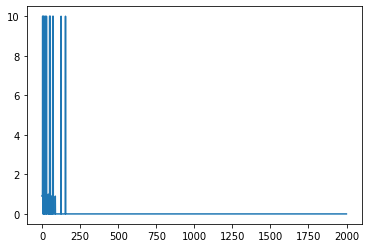

final policy:
---------------------------
  D  |  L  |  R  |     |
---------------------------
  D  |     |  D  |     |
---------------------------
  R  |  L  |  L  |  L  |


In [36]:
  # repeat until convergence
  deltas = []
  for t in range(2000):
    if t % 100 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # update policy
    for s in policy.keys():
      policy[s] = max_dict(Q[s])[0]

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

Notice how we have a few 100s in the deltas, this is because our initial policy contained actions that led to bumping into walls. 

The final policy makes sense, as do the values.

In [37]:
 # find V
  V = {}
  for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)

final values:
---------------------------
-0.90|-0.90| 1.00| 0.00|
---------------------------
-0.90| 0.00|-0.90| 0.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|


**Monte-Carlo Control without Exploring Start**

We can do this by using the $\epsilon$-greedy policy instead, that is there is a small chance that the agent will sometimes choose a random action instead of the action according to the greedy policy. 

In [0]:
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# NOTE: find optimal policy and value function
#       using on-policy first-visit MC

In [0]:
def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  # choose some other a' != a with probability eps/4
  p = np.random.random()
  # if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
  #   return a
  # else:
  #   tmp = list(ALL_POSSIBLE_ACTIONS)
  #   tmp.remove(a)
  #   return np.random.choice(tmp)
  #
  # this is equivalent to the above
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # in this version we will NOT use "exploring starts" method
  # instead we will explore using an epsilon-soft policy
  s = (2, 0) # fixed start location (randome start removed)
  grid.set_state(s)
  a = random_action(policy[s])

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else: # epsilon-greedy polic where we make use of random action from above
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [42]:
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [0]:
  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

In [44]:
  # repeat until convergence
  deltas = []
  for t in range(5000):
    if t % 1000 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)

    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
    for s in policy.keys():
      a, _ = max_dict(Q[s])
      policy[s] = a

0
1000
2000
3000
4000


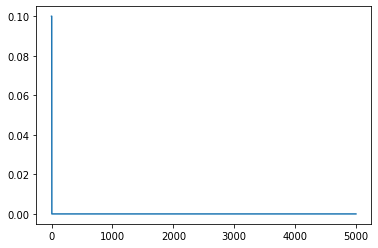

In [45]:
plt.plot(deltas)
plt.show()

In [46]:
  # find the optimal state-value function
  # V(s) = max[a]{ Q(s,a) }
  V = {}
  for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)
  print("final policy:")
  print_policy(policy, grid)

final values:
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
-0.10| 0.00| 0.00| 0.00|
final policy:
---------------------------
  U  |  U  |  U  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  U  |  U  |  U  |


## TD(0)

In [0]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

We have the same issue with TD as we do with MC and this is we never visit a state we'll never update its value, so if we have a deterministic policy without any explorationk some states won't have values, which is fine if we do not care about those values, but we want to add some exploraiton to make it more interesting. 

In [0]:
def random_action(a, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding rewards (not returns as in MC)
  # start at the designated start state
  s = (2, 0)
  grid.set_state(s)
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  return states_and_rewards

In [12]:
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {}
  states = grid.all_states()
  for s in states:
    V[s] = 0

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [13]:
  # repeat until convergence
  for it in range(1000):

    # generate an episode using pi
    states_and_rewards = play_game(grid, policy)
    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    for t in range(len(states_and_rewards) - 1):
      s, _ = states_and_rewards[t]
      s2, r = states_and_rewards[t+1]
      # we will update V(s) AS we experience the episode
      V[s] = V[s] + ALPHA*(r + GAMMA*V[s2] - V[s])

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

values:
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


## SARSA

 NOTE: if we use the standard grid, there's a good chance we will end up with
   suboptimal policies
   e.g.
   ---------------------------
     R  |   R  |   R  |      |
   ---------------------------
     R* |      |   U  |      |
   ---------------------------
     U  |   R  |   U  |   L  |
   since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
   we'll either end up staying in the same spot, or back to the start (2,0), at which
   point we whould then just go back up, or at (0,0), at which point we can continue
   on right.
   instead, let's penalize each movement so the agent will find a shorter route.


In [0]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [0]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [19]:
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated 
  update_counts = {} # (for debugging purposes)
  update_counts_sa = {} # (for the adaptive learning rate)
  for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      update_counts_sa[s][a] = 1.0

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [20]:
  # repeat until convergence
  t = 1.0
  deltas = []
  for it in range(10000):
    if it % 100 == 0:
      t += 1e-2
    if it % 2000 == 0:
      print("it:", it)

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a = max_dict(Q[s])[0]
    a = random_action(a, eps=0.5/t)
    biggest_change = 0
    while not grid.game_over():
      r = grid.move(a)
      s2 = grid.current_state()

      # we need the next action as well since Q(s,a) depends on Q(s',a')
      # if s2 not in policy then it's a terminal state, all Q are 0
      a2 = max_dict(Q[s2])[0]
      a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

      # we will update Q(s,a) AS we experience the episode
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005
      old_qsa = Q[s][a]
      Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # next state becomes current state
      s = s2
      a = a2

    deltas.append(biggest_change)

it: 0
it: 2000
it: 4000
it: 6000
it: 8000


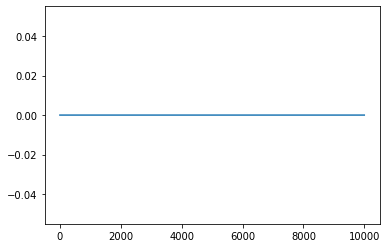

In [21]:
plt.plot(deltas)
plt.show()

In [0]:
  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

In [23]:
  # what's the proportion of time we spend updating each part of Q? (for debugging purposes)
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

update counts:
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
policy:
---------------------------
  U  |  U  |  U  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  U  |  U  |  U  |


## Q-Learning

In [0]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [0]:
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}
  update_counts_sa = {}
  for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      update_counts_sa[s][a] = 1.0

We employ adaptive epsilon (i.e. epsilon-greedy) and adaptive learning rate.

In [0]:
  # repeat until convergence
  t = 1.0
  deltas = []
  for it in range(10000):
    if it % 100 == 0:
      t += 1e-2
    if it % 2000 == 0:
      print("it:", it)

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a, _ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over():
      a = random_action(a, eps=0.5/t) # epsilon-greedy
      # random action also works, but slower since you can bump into walls
      # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      r = grid.move(a)
      s2 = grid.current_state()

      # adaptive learning rate
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005

      # we will update Q(s,a) AS we experience the episode
      old_qsa = Q[s][a]
      # the difference between SARSA and Q-Learning is with Q-Learning
      # we will use this max[a']{ Q(s',a')} in our update
      # even if we do not end up taking this action in the next step
      a2, max_q_s2a2 = max_dict(Q[s2])
      Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # next state becomes current state
      s = s2
      a = a2
     
    deltas.append(biggest_change)

In [0]:
plt.plot(deltas)
plt.show()

In [0]:
  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

In [0]:
  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

## Approximation with Monte-Carlo prediction problem

In [0]:
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

In [0]:
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
  }

In [0]:
def random_action(a):
  # choose given a with probability 0.5
  # choose some other a' != a with probability 0.5/3
  p = np.random.random()
  if p < 0.5:
    return a
  else:
    tmp = list(ALL_POSSIBLE_ACTIONS)
    tmp.remove(a)
    return np.random.choice(tmp)

def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

In [0]:
  # initialize theta
  # our model is V_hat = theta.dot(x)
  # where x = [row, col, row*col, 1] - 1 for bias term
  theta = np.random.randn(4) / 2 # randomly intialize the theta vector
  def s2x(s): # define a function that turns the state into a feature vector X.
    return np.array([s[0] - 1, s[1] - 1.5, s[0]*s[1] - 3, 1]) # 1 for the bias term. The only non-linear feature here is the interaction effect between the i and j coordinates.

In [0]:
LEARNING_RATE = 0.001 # used in gradient descent
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [0]:
  # repeat until convergence
  deltas = []
  t = 1.0
  for it in range(20000):
    if it % 100 == 0:
      t += 0.01
    alpha = LEARNING_RATE/t # decaying learning rate
    # generate an episode using pi
    biggest_change = 0
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        old_theta = theta.copy()
        x = s2x(s)
        V_hat = theta.dot(x)
        # grad(V_hat) wrt theta = x
        theta += alpha*(G - V_hat)*x
        biggest_change = max(biggest_change, np.abs(old_theta - theta).sum())
        seen_states.add(s)
    deltas.append(biggest_change)

In [0]:
plt.plot(deltas)
plt.show()

In [0]:
  # obtain predicted values
  V = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      V[s] = theta.dot(s2x(s))
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

In [0]:
  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

## TD(0) with approximation

Do not need to calculate returns, use rewards directly. 

In [0]:
# NOTE: this is only policy evaluation, not optimization

class Model:
  def __init__(self):
    self.theta = np.random.randn(4) / 2 # initialize data
  
  def s2x(self, s): # tranforms state into a feature vector, we are using the same features as in Monte-Carlo (these may not be good features)
    return np.array([s[0] - 1, s[1] - 1.5, s[0]*s[1] - 3, 1])

  def predict(self, s): # transforms a state s into a feature x and returns a dot product between theta and x
    x = self.s2x(s)
    return self.theta.dot(x) # linear model

  def grad(self, s):
    return self.s2x(s) # just transforms s into x

In [0]:
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = { # direct path to goal if not in that path we go directly to the loosing state.
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

In [0]:
# create a model
model = Model()
deltas = []

**Enter main loop - Game play**

In [0]:
  # repeat until convergence
  k = 1.0
  for it in range(20000):
    if it % 10 == 0:
      k += 0.01
    alpha = ALPHA/k
    biggest_change = 0

    # generate an episode using pi
    states_and_rewards = play_game(grid, policy)
    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    for t in range(len(states_and_rewards) - 1):
      s, _ = states_and_rewards[t]
      s2, r = states_and_rewards[t+1]
      # we will update V(s) AS we experience the episode
      old_theta = model.theta.copy()
      if grid.is_terminal(s2):
        target = r
      else:
        target = r + GAMMA*model.predict(s2)
      # update equation for theta
      model.theta += alpha*(target - model.predict(s))*model.grad(s)
      biggest_change = max(biggest_change, np.abs(old_theta - model.theta).sum())
    deltas.append(biggest_change)

In [0]:
plt.plot(deltas)
plt.show()

In [0]:
  # obtain predicted values
  V = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      V[s] = model.predict(s)
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

## Approxation Semi-Gradient SARSA Control Problem

In [0]:
 GAMMA, ALPHA, ALL_POSSIBLE_ACTIONS

In [0]:
class Model:
  def __init__(self):
    self.theta = np.random.randn(25) / np.sqrt(25)
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # print "D:", IDX
    # self.theta = np.random.randn(IDX) / np.sqrt(IDX)

  def sa2x(self, s, a):
    # NOTE: using just (r, c, r*c, u, d, l, r, 1) is not expressive enough
    return np.array([ # dimension 25 (5 actions x 5 engineered features)
      s[0] - 1              if a == 'U' else 0,
      s[1] - 1.5            if a == 'U' else 0,
      (s[0]*s[1] - 3)/3     if a == 'U' else 0,
      (s[0]*s[0] - 2)/2     if a == 'U' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
      1                     if a == 'U' else 0,
      s[0] - 1              if a == 'D' else 0,
      s[1] - 1.5            if a == 'D' else 0,
      (s[0]*s[1] - 3)/3     if a == 'D' else 0,
      (s[0]*s[0] - 2)/2     if a == 'D' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
      1                     if a == 'D' else 0,
      s[0] - 1              if a == 'L' else 0,
      s[1] - 1.5            if a == 'L' else 0,
      (s[0]*s[1] - 3)/3     if a == 'L' else 0,
      (s[0]*s[0] - 2)/2     if a == 'L' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
      1                     if a == 'L' else 0,
      s[0] - 1              if a == 'R' else 0,
      s[1] - 1.5            if a == 'R' else 0,
      (s[0]*s[1] - 3)/3     if a == 'R' else 0,
      (s[0]*s[0] - 2)/2     if a == 'R' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
      1                     if a == 'R' else 0,
      1
    ])
    # UNCOMMENT TO DO REGULAR SARSA METHOD
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # x = np.zeros(len(self.theta))
    # idx = SA2IDX[s][a]
    # x[idx] = 1
    # return x

  def predict(self, s, a):
    x = self.sa2x(s, a)
    return self.theta.dot(x)

  def grad(self, s, a):
    return self.sa2x(s, a)

In [0]:
def getQs(model, s): # job of this fuction is to turn Q-predictions into a dictionary given some state s. 
  # we need Q(s,a) to choose an action
  # i.e. a = argmax[a]{ Q(s,a) }
  Qs = {}
  for a in ALL_POSSIBLE_ACTIONS:
    q_sa = model.predict(s, a)
    Qs[a] = q_sa
  return Qs

In [0]:
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q
  # enumerate all (s,a) pairs, each will have its own weight in our "dumb" model
  # essentially each weight will be a measure of Q(s,a) itself
  states = grid.all_states()
  for s in states:
    SA2IDX[s] = {}
    for a in ALL_POSSIBLE_ACTIONS: # populate the SA2IDX dictionary
      SA2IDX[s][a] = IDX
      IDX += 1

In [0]:
# initialize model
model = Model()

**Enter the main loop**

Here we have two time variables t1 and t2 (these are hyper-parameters), since we want the learning rate and  epsilon to decrease at different rates.

In [0]:
  # repeat until convergence
  t = 1.0
  t2 = 1.0
  deltas = []
  for it in range(20000):
    if it % 100 == 0:
      t += 0.01
      t2 += 0.01
    if it % 1000 == 0:
      print("it:", it)
    alpha = ALPHA / t2

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # get Q(s) so we can choose the first action
    Qs = getQs(model, s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a = max_dict(Qs)[0]
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    biggest_change = 0
    while not grid.game_over():
      r = grid.move(a)
      s2 = grid.current_state()

      # we need the next action as well since Q(s,a) depends on Q(s',a')
      # if s2 not in policy then it's a terminal state, all Q are 0
      old_theta = model.theta.copy()
      if grid.is_terminal(s2):
        model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
      else:
        # not terminal
        Qs2 = getQs(model, s2)
        a2 = max_dict(Qs2)[0]
        a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

        # we will update Q(s,a) AS we experience the episode
        model.theta += alpha*(r + GAMMA*model.predict(s2, a2) - model.predict(s, a))*model.grad(s, a)
        
        # next state becomes current state
        s = s2
        a = a2

      biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
    deltas.append(biggest_change)

In [0]:
plt.plot(deltas)
plt.show()

In [0]:
  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  Q = {}
  for s in grid.actions.keys():
    Qs = getQs(model, s)
    Q[s] = Qs
    a, max_q = max_dict(Qs)
    policy[s] = a
    V[s] = max_q

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

## Approxation Q-Learning

In [0]:
GAMMA, ALPHA, ALL_POSSIBLE_ACTIONS

In [0]:

SA2IDX = {}
IDX = 0

In [0]:
def random_action(a, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
class Model:
  def __init__(self):
    self.theta = np.random.randn(25) / np.sqrt(25)
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # print "D:", IDX
    # self.theta = np.random.randn(IDX) / np.sqrt(IDX)

  def sa2x(self, s, a):
    # NOTE: using just (r, c, r*c, u, d, l, r, 1) is not expressive enough
    return np.array([
      s[0] - 1              if a == 'U' else 0,
      s[1] - 1.5            if a == 'U' else 0,
      (s[0]*s[1] - 3)/3     if a == 'U' else 0,
      (s[0]*s[0] - 2)/2     if a == 'U' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
      1                     if a == 'U' else 0,
      s[0] - 1              if a == 'D' else 0,
      s[1] - 1.5            if a == 'D' else 0,
      (s[0]*s[1] - 3)/3     if a == 'D' else 0,
      (s[0]*s[0] - 2)/2     if a == 'D' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
      1                     if a == 'D' else 0,
      s[0] - 1              if a == 'L' else 0,
      s[1] - 1.5            if a == 'L' else 0,
      (s[0]*s[1] - 3)/3     if a == 'L' else 0,
      (s[0]*s[0] - 2)/2     if a == 'L' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
      1                     if a == 'L' else 0,
      s[0] - 1              if a == 'R' else 0,
      s[1] - 1.5            if a == 'R' else 0,
      (s[0]*s[1] - 3)/3     if a == 'R' else 0,
      (s[0]*s[0] - 2)/2     if a == 'R' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
      1                     if a == 'R' else 0,
      1
    ])
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # x = np.zeros(len(self.theta))
    # idx = SA2IDX[s][a]
    # x[idx] = 1
    # return x

  def predict(self, s, a):
    x = self.sa2x(s, a)
    return self.theta.dot(x)

  def grad(self, s, a):
    return self.sa2x(s, a)

In [0]:
def getQs(model, s):
  # we need Q(s,a) to choose an action
  # i.e. a = argmax[a]{ Q(s,a) }
  Qs = {}
  for a in ALL_POSSIBLE_ACTIONS:
    q_sa = model.predict(s, a)
    Qs[a] = q_sa
  return Qs

In [0]:
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

In [0]:
  # no policy initialization, we will derive our policy from most recent Q
  # enumerate all (s,a) pairs, each will have its own weight in our "dumb" model
  # essentially each weight will be a measure of Q(s,a) itself
  states = grid.all_states()
  for s in states:
    SA2IDX[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      SA2IDX[s][a] = IDX
      IDX += 1

In [0]:
# initialize model
  model = Model()

In [0]:
  # repeat until convergence
  t = 1.0
  t2 = 1.0
  deltas = []
  for it in range(20000):
    if it % 100 == 0:
      t += 0.01
      t2 += 0.01
    if it % 1000 == 0:
      print("it:", it)
    alpha = ALPHA / t2

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # get Q(s) so we can choose the first action
    Qs = getQs(model, s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a = max_dict(Qs)[0]
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    biggest_change = 0
    while not grid.game_over():
      r = grid.move(a)
      s2 = grid.current_state()

      # we need the next action as well since Q(s,a) depends on Q(s',a')
      # if s2 not in policy then it's a terminal state, all Q are 0
      old_theta = model.theta.copy()
      if grid.is_terminal(s2):
        model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
      else:
        # not terminal
        Qs2 = getQs(model, s2)
        a2, maxQs2a2 = max_dict(Qs2)
        a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

        # we will update Q(s,a) AS we experience the episode
        model.theta += alpha*(r + GAMMA*maxQs2a2 - model.predict(s, a))*model.grad(s, a)
        
        # next state becomes current state
        s = s2
        a = a2

      biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
    deltas.append(biggest_change)

In [0]:
plt.plot(deltas)
plt.show()

In [0]:
  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  Q = {}
  for s in grid.actions.keys():
    Qs = getQs(model, s)
    Q[s] = Qs
    a, max_q = max_dict(Qs)
    policy[s] = a
    V[s] = max_q

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)